In [1]:
import time
import spo
import torch
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm
torch.manual_seed(135)

## Init Data

In [2]:
# generate data for grid network (features and costs)
m = 48 # number of items
n = 1000 # number of data
p = 5 # size of feature
deg = 4 # polynomial degree
weights, x, c = spo.data.knapsack.genData(n+1000, p, m, deg=deg, dim=3)

In [3]:
weights

array([[4.59, 4.87, 5.19, 7.59, 6.8 , 4.97, 4.84, 3.22, 7.9 , 3.62, 3.12,
        6.81, 7.09, 3.23, 4.47, 5.23, 6.11, 5.23, 4.27, 6.66, 5.21, 3.72,
        7.83, 5.64, 7.56, 3.28, 4.31, 3.85, 6.43, 4.26, 7.56, 6.4 , 6.09,
        6.4 , 4.5 , 6.31, 6.35, 3.07, 6.03, 7.39, 3.48, 5.57, 6.27, 4.55,
        5.64, 5.66, 3.27, 6.68],
       [4.2 , 5.61, 6.13, 7.88, 4.61, 4.92, 6.09, 7.95, 7.11, 4.02, 3.07,
        7.84, 6.29, 5.78, 5.57, 5.65, 7.41, 5.21, 3.42, 6.48, 5.77, 7.67,
        7.32, 3.31, 4.36, 4.75, 3.38, 3.44, 6.3 , 4.85, 7.09, 5.7 , 4.05,
        6.04, 6.51, 3.41, 7.94, 6.05, 7.18, 3.64, 4.35, 4.45, 4.27, 4.87,
        5.74, 3.16, 5.41, 3.81],
       [3.51, 5.98, 5.79, 6.62, 5.11, 3.16, 7.01, 6.48, 6.36, 4.12, 7.9 ,
        7.69, 3.68, 4.73, 5.85, 5.03, 3.69, 7.13, 7.11, 5.72, 5.8 , 4.59,
        6.85, 4.14, 6.18, 4.28, 5.38, 5.79, 6.78, 3.79, 4.61, 3.06, 7.78,
        3.94, 6.06, 7.22, 5.18, 3.44, 3.93, 5.56, 3.56, 6.59, 5.  , 5.24,
        7.94, 6.75, 6.37, 7.64]])

In [4]:
# convert max into min
c = - c

## Optimization Model 

In [5]:
# capacity
caps = [30, 30, 30]

In [6]:
ks_model = spo.model.grb.knapsackModel(weights, caps)

Academic license - for non-commercial use only - expires 2021-10-08
Using license file C:\Users\Apocrypse\gurobi.lic


In [7]:
# solve
ks_model.setObj([-i for i in range(m)])
sol, obj = ks_model.solve()
print(sol)
print('Obj: {}'.format(obj))
for i in ks_model.items:
    if sol[i] > 1e-3:
        print(i)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0]
Obj: -247.0
37
39
40
42
43
46


In [8]:
# relax
ks_model_rel = ks_model.relax()

In [9]:
# solve
ks_model_rel.setObj([-i for i in range(m)])
sol, obj = ks_model_rel.solve()
print(sol)
print('Obj: {}'.format(obj))
for i in ks_model_rel.items:
    if sol[i] > 1e-3:
        print(i)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7341529483956307, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.07483910802382839, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.525492392040327, 0.0]
Obj: -256.85011664704894
31
37
39
40
42
43
45
46


## Data Loader 

In [10]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

In [11]:
# data split
x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=1000, random_state=246)

In [12]:
# get training data set
ks_dataset_train = spo.data.dataset.optDataset(ks_model, x_train, c_train)

Optimizing for optDataset...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 75.84it/s]


In [13]:
# get training data set for relaxation
ks_dataset_train_rel = spo.data.dataset.optDataset(ks_model_rel, x_train, c_train)

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 432.06it/s]


In [14]:
# get test data set
ks_dataset_test = spo.data.dataset.optDataset(ks_model, x_test, c_test)

Optimizing for optDataset...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 99.87it/s]


In [15]:
# get data loader
batch_size = 32
ks_loader_train = DataLoader(ks_dataset_train, batch_size=batch_size, shuffle=True)
ks_loader_train_rel = DataLoader(ks_dataset_train_rel, batch_size=batch_size, shuffle=True)
ks_loader_test = DataLoader(ks_dataset_test, batch_size=batch_size, shuffle=False)

In [16]:
for i, data in enumerate(ks_loader_train):
    x, c, w, z = data
    break

In [17]:
x.shape

torch.Size([32, 5])

In [18]:
c.shape

torch.Size([32, 48])

In [19]:
w.shape

torch.Size([32, 48])

In [20]:
z.shape

torch.Size([32, 1])

## Linear Regression from Scikit-Lear 

In [21]:
from sklearn.linear_model import LinearRegression

In [22]:
# prediction model
reg = LinearRegression()

## Two-Stage 

In [23]:
# build model
twostage_model = spo.twostage.sklearnPred(reg, ks_model)

In [24]:
# training
twostage_model.fit(ks_dataset_train.x, ks_dataset_train.c)

In [25]:
# prediction
c_test_pred = twostage_model.predict(ks_dataset_test.x)

In [26]:
# evaluate
truespo = 0
unambspo = 0
for i in tqdm(range(1000)):
    c_pred_i = c_test_pred[i]
    c_true_i = ks_dataset_test.c[i]
    z_true_i = ks_dataset_test.z[i,0]
    truespo += spo.eval.calTrueSPO(ks_model, c_pred_i, c_true_i, z_true_i)
    unambspo += spo.eval.calUnambSPO(ks_model, c_pred_i, c_true_i, z_true_i)
time.sleep(1)
print('Normalized true SPO Loss: {:.2f}%'.format(truespo / abs(ks_dataset_test.z.sum()) * 100))
print('Normalized unambiguous SPO Loss: {:.2f}%'.format(unambspo / abs(ks_dataset_test.z.sum()) * 100))

100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [01:03<00:00, 15.69it/s]


Normalized true SPO Loss: 2.48%
Normalized unambiguous SPO Loss: 2.48%


In [27]:
# compare solutions
for i, data in enumerate(ks_loader_test):
    # load data
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # convert to numpy
    x = x.to('cpu').detach().numpy()
    c = c.to('cpu').detach().numpy()
    w = w.to('cpu').detach().numpy()
    z = z.to('cpu').detach().numpy()
    # predict
    cp = twostage_model.predict(x)
    for j in range(min(10, batch_size)):
        print('Sample {}:'.format(j))
        print('    True cost:', ', '.join(['{:.2f}'.format(-cost) for cost in c[j]]))
        print('    Pred cost:', ', '.join(['{:.2f}'.format(-cost) for cost in cp[j]]))
        # solve cost from prediction
        ks_model.setObj(cp[j])
        wpj, _ = ks_model.solve()
        zpj = np.dot(c[j], wpj)
        print('    True sol: ' + ', '.join(['{:.0f}'.format(x) for x in w[j]]) + ', True obj: {:.2f}'.format(-z[j,0]))
        print('    Pred sol: '+  ', '.join(['{:.0f}'.format(x) for x in wpj]) + ', Pred obj: {:.2f}'.format(-zpj))
        print()
    break

Sample 0:
    True cost: 10.00, 8.00, 8.00, 9.00, 8.00, 5.00, 8.00, 9.00, 5.00, 6.00, 7.00, 7.00, 7.00, 6.00, 6.00, 9.00, 8.00, 9.00, 9.00, 6.00, 6.00, 7.00, 6.00, 9.00, 8.00, 8.00, 8.00, 5.00, 8.00, 5.00, 5.00, 8.00, 6.00, 6.00, 8.00, 8.00, 5.00, 9.00, 5.00, 6.00, 9.00, 5.00, 8.00, 5.00, 8.00, 8.00, 5.00, 7.00
    Pred cost: 12.48, 9.70, 8.50, 11.08, 11.19, 6.31, 8.50, 11.19, 5.28, 6.60, 9.71, 9.72, 9.72, 7.72, 7.70, 9.83, 12.40, 9.83, 10.98, 6.00, 7.70, 9.71, 7.70, 9.78, 8.50, 10.96, 11.19, 6.40, 12.40, 7.55, 7.41, 12.40, 6.60, 6.60, 12.40, 8.50, 6.31, 9.83, 7.41, 7.70, 9.78, 5.28, 10.95, 6.34, 11.19, 12.40, 6.34, 9.72
    True sol: 1, -0, -0, -0, -0, -0, -0, -0, -0, 1, -0, -0, -0, -0, -0, -0, -0, -0, -0, -0, -0, -0, -0, 1, -0, 1, -0, -0, -0, -0, -0, -0, -0, -0, -0, -0, -0, 1, -0, -0, 1, -0, -0, -0, -0, 1, -0, -0, True obj: 59.00
    Pred sol: 1, 0, 0, 0, 0, 0, 0, 0, -0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -0, 0, 0, -0, 0, 0, 1, 1, 0, 0, 0, -0, 1, 0, 0, 1, 0, -0, 0, 0, 0, 0, 0, 0, 0, 0, 1,

## Linear Regression from PyTorch

In [28]:
from torch import nn

In [29]:
# build linear model
class LinearRegression(nn.Module):
    
    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(p, m)
    
    def forward(self, x):
        out = self.linear(x)
        return out

## SPO+ 

In [30]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

In [31]:
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=1e-2)

In [32]:
# init SPO+ loss
criterion = spo.func.SPOPlus(ks_model, processes=4)

Num of cores: 4


In [33]:
# train model
num_epochs = 300
reg.train()
loss_log = []
loss_log_truespo = []
loss_log_unambspo = []
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(ks_loader_train):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # forward pass
        cp = reg(x)
        loss = criterion.apply(cp, c, w, z).mean()
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_log.append(loss.item())
    if (epoch + 1) % 10 == 0:
        # true SPO
        trueloss = spo.eval.trueSPO(reg, ks_model, ks_loader_test)
        loss_log_truespo.append(trueloss)
        # unambiguous SPO 
        unambloss = spo.eval.unambSPO(reg, ks_model, ks_loader_test)
        loss_log_unambspo.append(unambloss)
        print('Epoch {:3}, Loss: {:8.4f}, True SPO Loss: {:7.4f}%, Unambiguous SPO Loss: {:7.4f}%'. \
              format(epoch+1, loss.item(), trueloss*100, unambloss*100))

Epoch  10, Loss:  50.8866, True SPO Loss:  6.8456%, Unambiguous SPO Loss:  6.8456%
Epoch  20, Loss:  84.0298, True SPO Loss:  1.4410%, Unambiguous SPO Loss:  1.4410%
Epoch  30, Loss:  37.2820, True SPO Loss:  0.7558%, Unambiguous SPO Loss:  0.7558%
Epoch  40, Loss:  11.3165, True SPO Loss:  0.5749%, Unambiguous SPO Loss:  0.5749%
Epoch  50, Loss:  38.3847, True SPO Loss:  0.4760%, Unambiguous SPO Loss:  0.4760%
Epoch  60, Loss:  20.4938, True SPO Loss:  0.4388%, Unambiguous SPO Loss:  0.4388%
Epoch  70, Loss:   7.8921, True SPO Loss:  0.4465%, Unambiguous SPO Loss:  0.4465%
Epoch  80, Loss:   2.5168, True SPO Loss:  0.3516%, Unambiguous SPO Loss:  0.3516%
Epoch  90, Loss:  11.2493, True SPO Loss:  0.4222%, Unambiguous SPO Loss:  0.4222%
Epoch 100, Loss:   1.7557, True SPO Loss:  0.3811%, Unambiguous SPO Loss:  0.3811%
Epoch 110, Loss:   2.4651, True SPO Loss:  0.3490%, Unambiguous SPO Loss:  0.3490%
Epoch 120, Loss:   0.9792, True SPO Loss:  0.3554%, Unambiguous SPO Loss:  0.3554%
Epoc

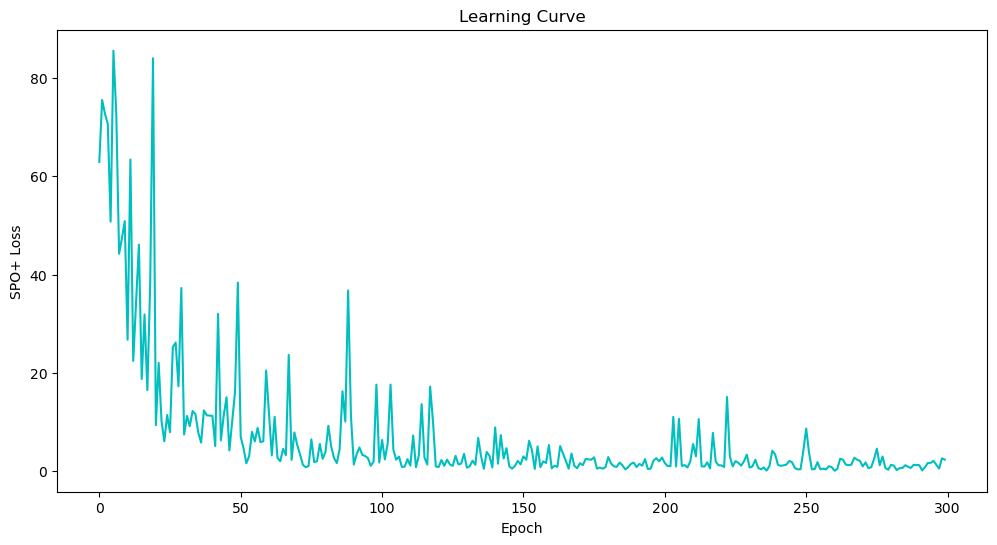

In [34]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(loss_log, color='c')
plt.xlabel('Epoch')
plt.ylabel('SPO+ Loss')
plt.title('Learning Curve')
plt.show()

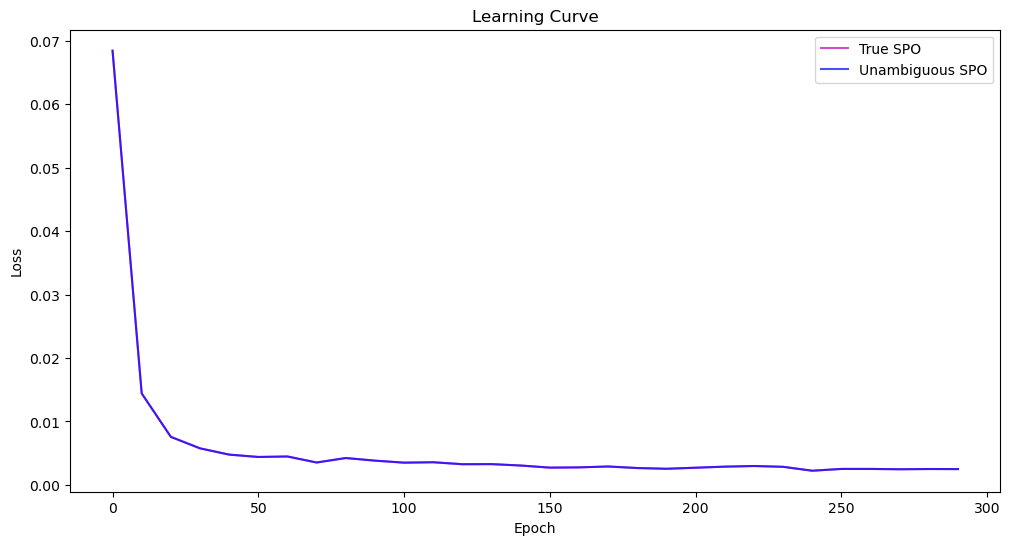

In [35]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(range(0, num_epochs, 10), loss_log_truespo, color='m', alpha=0.7, label='True SPO')
plt.plot(range(0, num_epochs, 10), loss_log_unambspo, color='b', alpha=0.7, label='Unambiguous SPO')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

In [36]:
# evaluate
spoloss = spo.eval.trueSPO(reg, ks_model, ks_loader_test)
print('Normalized true SPO Loss: {:.2f}%'.format(spoloss * 100))
spoloss = spo.eval.unambSPO(reg, ks_model, ks_loader_test)
print('Normalized unambiguous SPO Loss: {:.2f}%'.format(spoloss * 100))

Normalized true SPO Loss: 0.25%
Normalized unambiguous SPO Loss: 0.25%


In [37]:
reg.eval()
# compare solutions
for i, data in enumerate(ks_loader_test):
    # load data
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # predict
    cp = reg(x)
    # convert to numpy
    x = x.to('cpu').detach().numpy()
    c = c.to('cpu').detach().numpy()
    w = w.to('cpu').detach().numpy()
    z = z.to('cpu').detach().numpy()
    cp = cp.to('cpu').detach().numpy()
    for j in range(min(10, batch_size)):
        print('Sample {}:'.format(j))
        print('    True cost:', ', '.join(['{:.2f}'.format(-cost) for cost in c[j]]))
        print('    Pred cost:', ', '.join(['{:.2f}'.format(-cost) for cost in cp[j]]))
        # solve cost from prediction
        ks_model.setObj(cp[j])
        wpj, _ = ks_model.solve()
        zpj = np.dot(c[j], wpj)
        print('    True sol: ' + ', '.join(['{:.0f}'.format(x) for x in w[j]]) + ', True obj: {:.2f}'.format(-z[j,0]))
        print('    Pred sol: '+  ', '.join(['{:.0f}'.format(x) for x in wpj]) + ', Pred obj: {:.2f}'.format(-zpj))
        print()
    break

Sample 0:
    True cost: 10.00, 8.00, 8.00, 9.00, 8.00, 5.00, 8.00, 9.00, 5.00, 6.00, 7.00, 7.00, 7.00, 6.00, 6.00, 9.00, 8.00, 9.00, 9.00, 6.00, 6.00, 7.00, 6.00, 9.00, 8.00, 8.00, 8.00, 5.00, 8.00, 5.00, 5.00, 8.00, 6.00, 6.00, 8.00, 8.00, 5.00, 9.00, 5.00, 6.00, 9.00, 5.00, 8.00, 5.00, 8.00, 8.00, 5.00, 7.00
    Pred cost: 11.22, 8.08, 8.50, 10.67, 7.70, 4.96, 9.17, 10.42, 2.82, 6.01, 7.14, 8.50, 7.41, 6.66, 6.12, 9.88, 9.47, 9.67, 10.63, 5.87, 5.90, 7.43, 5.57, 9.94, 8.83, 9.10, 8.29, 4.40, 9.22, 4.83, 2.15, 9.53, 5.75, 5.84, 8.23, 8.98, 2.94, 10.15, 3.07, 5.92, 10.04, 2.97, 8.37, 4.39, 7.98, 9.32, 4.12, 7.16
    True sol: 1, -0, -0, -0, -0, -0, -0, -0, -0, 1, -0, -0, -0, -0, -0, -0, -0, -0, -0, -0, -0, -0, -0, 1, -0, 1, -0, -0, -0, -0, -0, -0, -0, -0, -0, -0, -0, 1, -0, -0, 1, -0, -0, -0, -0, 1, -0, -0, True obj: 59.00
    Pred sol: 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, Pred o

## SPO+ with Regularization

In [38]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

In [39]:
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=1e-2)

In [40]:
# init SPO+ loss
criterion = spo.func.SPOPlus(ks_model, processes=4)

Num of cores: 4


In [41]:
# train model
num_epochs = 300
reg.train()
loss_log = []
loss_log_truespo = []
loss_log_unambspo = []
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(ks_loader_train):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # forward pass
        cp = reg(x)
        loss = criterion.apply(cp, c, w, z).mean()
        # l1 reg
        l1_lambda = 1e-3
        l1_reg = torch.abs(cp - c).sum(dim=1).mean()
        loss += l1_lambda * l1_reg
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_log.append(loss.item())
    if (epoch + 1) % 10 == 0:
        # true SPO
        trueloss = spo.eval.trueSPO(reg, ks_model, ks_loader_test)
        loss_log_truespo.append(trueloss)
        # unambiguous SPO 
        unambloss = spo.eval.unambSPO(reg, ks_model, ks_loader_test)
        loss_log_unambspo.append(unambloss)
        print('Epoch {:3}, Loss: {:8.4f}, True SPO Loss: {:7.4f}%, Unambiguous SPO Loss: {:7.4f}%'. \
              format(epoch+1, loss.item(), trueloss*100, unambloss*100))

Epoch  10, Loss:  30.8227, True SPO Loss:  8.9551%, Unambiguous SPO Loss:  8.9551%
Epoch  20, Loss:  25.0210, True SPO Loss:  1.5873%, Unambiguous SPO Loss:  1.5873%
Epoch  30, Loss:  17.0473, True SPO Loss:  0.8520%, Unambiguous SPO Loss:  0.8520%
Epoch  40, Loss:   5.9809, True SPO Loss:  0.5659%, Unambiguous SPO Loss:  0.5659%
Epoch  50, Loss:  12.5619, True SPO Loss:  0.4696%, Unambiguous SPO Loss:  0.4696%
Epoch  60, Loss:   5.2644, True SPO Loss:  0.4337%, Unambiguous SPO Loss:  0.4337%
Epoch  70, Loss:   0.9980, True SPO Loss:  0.3837%, Unambiguous SPO Loss:  0.3837%
Epoch  80, Loss:   1.3149, True SPO Loss:  0.3875%, Unambiguous SPO Loss:  0.3875%
Epoch  90, Loss:   6.0590, True SPO Loss:  0.3593%, Unambiguous SPO Loss:  0.3593%
Epoch 100, Loss:   1.0577, True SPO Loss:  0.3631%, Unambiguous SPO Loss:  0.3631%
Epoch 110, Loss:   4.5001, True SPO Loss:  0.3169%, Unambiguous SPO Loss:  0.3169%
Epoch 120, Loss:   2.6590, True SPO Loss:  0.2861%, Unambiguous SPO Loss:  0.2861%
Epoc

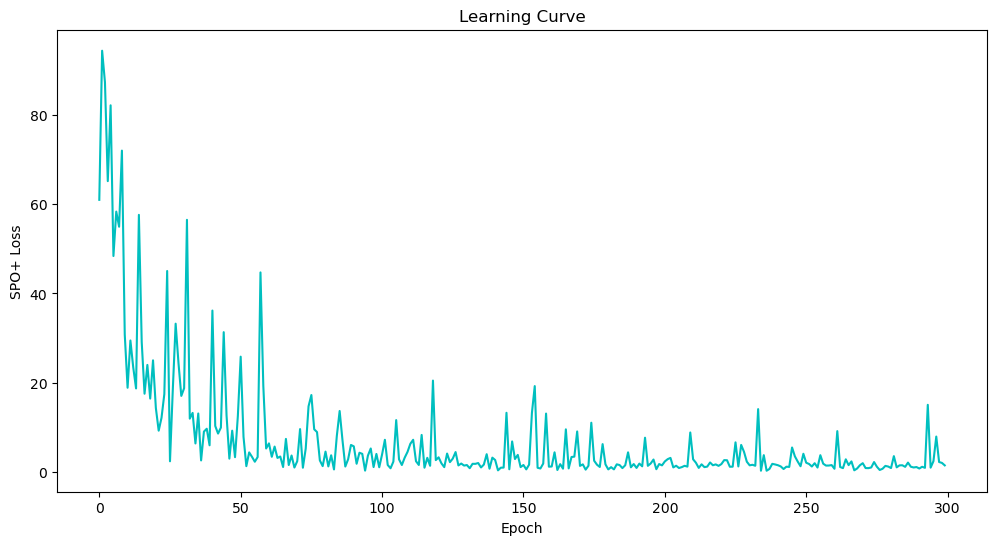

In [42]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(loss_log, color='c')
plt.xlabel('Epoch')
plt.ylabel('SPO+ Loss')
plt.title('Learning Curve')
plt.show()

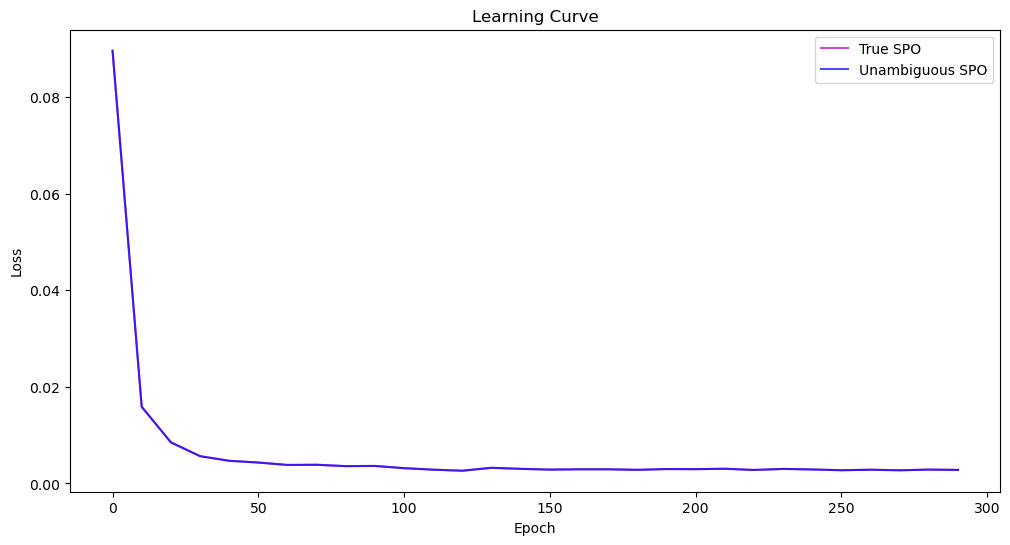

In [43]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(range(0, num_epochs, 10), loss_log_truespo, color='m', alpha=0.7, label='True SPO')
plt.plot(range(0, num_epochs, 10), loss_log_unambspo, color='b', alpha=0.7, label='Unambiguous SPO')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

In [44]:
# evaluate
spoloss = spo.eval.trueSPO(reg, ks_model, ks_loader_test)
print('Normalized true SPO Loss: {:.2f}%'.format(spoloss * 100))
spoloss = spo.eval.unambSPO(reg, ks_model, ks_loader_test)
print('Normalized unambiguous SPO Loss: {:.2f}%'.format(spoloss * 100))

Normalized true SPO Loss: 0.28%
Normalized unambiguous SPO Loss: 0.28%


In [45]:
reg.eval()
# compare solutions
for i, data in enumerate(ks_loader_test):
    # load data
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # predict
    cp = reg(x)
    # convert to numpy
    x = x.to('cpu').detach().numpy()
    c = c.to('cpu').detach().numpy()
    w = w.to('cpu').detach().numpy()
    z = z.to('cpu').detach().numpy()
    cp = cp.to('cpu').detach().numpy()
    for j in range(min(10, batch_size)):
        print('Sample {}:'.format(j))
        print('    True cost:', ', '.join(['{:.2f}'.format(-cost) for cost in c[j]]))
        print('    Pred cost:', ', '.join(['{:.2f}'.format(-cost) for cost in cp[j]]))
        # solve cost from prediction
        ks_model.setObj(cp[j])
        wpj, _ = ks_model.solve()
        zpj = np.dot(c[j], wpj)
        print('    True sol: ' + ', '.join(['{:.0f}'.format(x) for x in w[j]]) + ', True obj: {:.2f}'.format(-z[j,0]))
        print('    Pred sol: '+  ', '.join(['{:.0f}'.format(x) for x in wpj]) + ', Pred obj: {:.2f}'.format(-zpj))
        print()
    break

Sample 0:
    True cost: 10.00, 8.00, 8.00, 9.00, 8.00, 5.00, 8.00, 9.00, 5.00, 6.00, 7.00, 7.00, 7.00, 6.00, 6.00, 9.00, 8.00, 9.00, 9.00, 6.00, 6.00, 7.00, 6.00, 9.00, 8.00, 8.00, 8.00, 5.00, 8.00, 5.00, 5.00, 8.00, 6.00, 6.00, 8.00, 8.00, 5.00, 9.00, 5.00, 6.00, 9.00, 5.00, 8.00, 5.00, 8.00, 8.00, 5.00, 7.00
    Pred cost: 10.27, 7.54, 8.71, 9.93, 7.12, 4.41, 8.84, 9.48, 4.44, 6.18, 7.44, 7.84, 7.27, 5.90, 5.74, 9.39, 8.04, 8.93, 9.32, 5.53, 5.58, 7.58, 5.51, 8.98, 8.69, 8.41, 7.81, 4.61, 8.90, 4.08, 3.14, 8.30, 5.74, 5.27, 7.09, 8.60, 3.47, 9.31, 3.61, 5.32, 9.15, 4.14, 7.54, 3.84, 8.33, 7.98, 3.85, 6.56
    True sol: 1, -0, -0, -0, -0, -0, -0, -0, -0, 1, -0, -0, -0, -0, -0, -0, -0, -0, -0, -0, -0, -0, -0, 1, -0, 1, -0, -0, -0, -0, -0, -0, -0, -0, -0, -0, -0, 1, -0, -0, 1, -0, -0, -0, -0, 1, -0, -0, True obj: 59.00
    Pred sol: 1, -0, -0, -0, -0, -0, -0, -0, -0, 1, -0, -0, -0, -0, -0, -0, -0, -0, -0, -0, -0, -0, -0, 1, -0, 1, -0, -0, -0, -0, -0, -0, -0, -0, -0, -0, -0, 1, -0, -0, 

## SPO+ Rel 

In [46]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

In [47]:
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=1e-2)

In [48]:
# init SPO+ loss
criterion = spo.func.SPOPlus(ks_model_rel, processes=4)

Num of cores: 4


In [49]:
# train model
num_epochs = 300
reg.train()
loss_log = []
loss_log_truespo = []
loss_log_unambspo = []
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(ks_loader_train_rel):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # forward pass
        cp = reg(x)
        loss = criterion.apply(cp, c, w, z).mean()
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_log.append(loss.item())
    if (epoch + 1) % 10 == 0:
        # true SPO
        trueloss = spo.eval.trueSPO(reg, ks_model, ks_loader_test)
        loss_log_truespo.append(trueloss)
        # unambiguous SPO 
        unambloss = spo.eval.unambSPO(reg, ks_model, ks_loader_test)
        loss_log_unambspo.append(unambloss)
        print('Epoch {:3}, Loss: {:8.4f}, True SPO Loss: {:7.4f}%, Unambiguous SPO Loss: {:7.4f}%'. \
              format(epoch+1, loss.item(), trueloss*100, unambloss*100))

Epoch  10, Loss:  61.9945, True SPO Loss:  5.2827%, Unambiguous SPO Loss:  5.2827%
Epoch  20, Loss:  17.6073, True SPO Loss:  1.6514%, Unambiguous SPO Loss:  1.6514%
Epoch  30, Loss:   6.7247, True SPO Loss:  0.8161%, Unambiguous SPO Loss:  0.8161%
Epoch  40, Loss:  14.1481, True SPO Loss:  0.6249%, Unambiguous SPO Loss:  0.6249%
Epoch  50, Loss:   3.7608, True SPO Loss:  0.5607%, Unambiguous SPO Loss:  0.5607%
Epoch  60, Loss:   2.2887, True SPO Loss:  0.4773%, Unambiguous SPO Loss:  0.4773%
Epoch  70, Loss:   1.7044, True SPO Loss:  0.4671%, Unambiguous SPO Loss:  0.4671%
Epoch  80, Loss:   1.2282, True SPO Loss:  0.4157%, Unambiguous SPO Loss:  0.4157%
Epoch  90, Loss:   2.3279, True SPO Loss:  0.4080%, Unambiguous SPO Loss:  0.4080%
Epoch 100, Loss:   2.5330, True SPO Loss:  0.4055%, Unambiguous SPO Loss:  0.4055%
Epoch 110, Loss:   0.8595, True SPO Loss:  0.4093%, Unambiguous SPO Loss:  0.4093%
Epoch 120, Loss:   1.3274, True SPO Loss:  0.4003%, Unambiguous SPO Loss:  0.4003%
Epoc

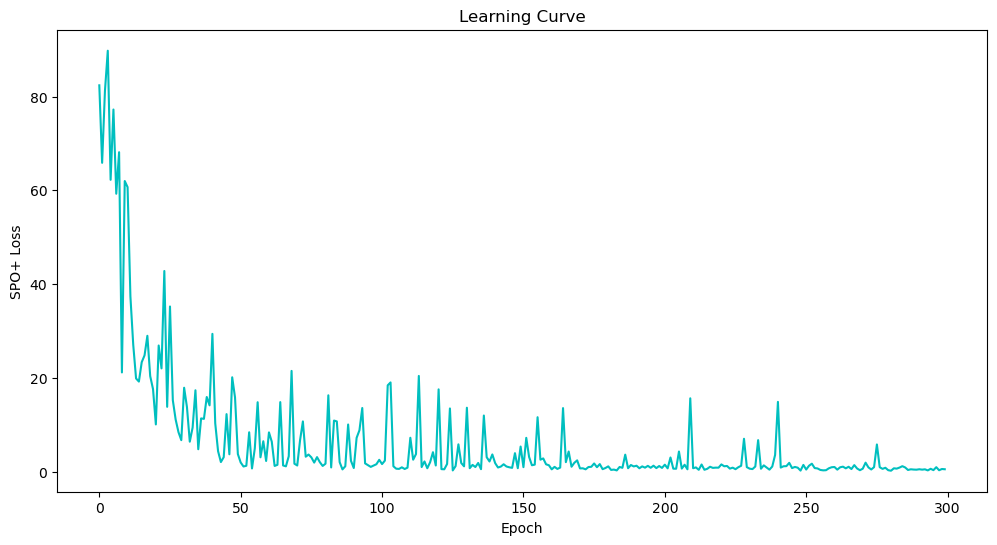

In [50]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(loss_log, color='c')
plt.xlabel('Epoch')
plt.ylabel('SPO+ Loss')
plt.title('Learning Curve')
plt.show()

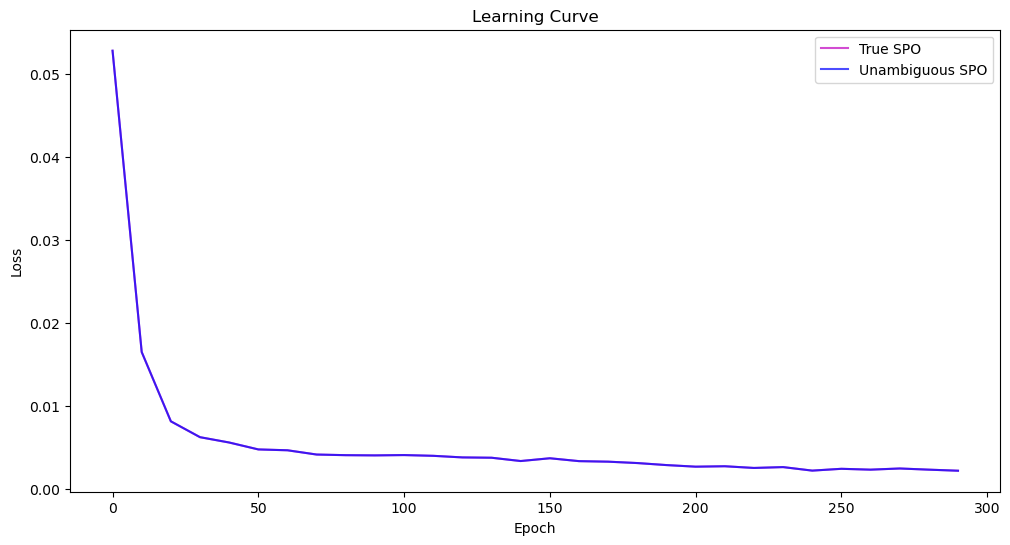

In [51]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(range(0, num_epochs, 10), loss_log_truespo, color='m', alpha=0.7, label='True SPO')
plt.plot(range(0, num_epochs, 10), loss_log_unambspo, color='b', alpha=0.7, label='Unambiguous SPO')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

In [52]:
# evaluate
spoloss = spo.eval.trueSPO(reg, ks_model, ks_loader_test)
print('Normalized true SPO Loss: {:.2f}%'.format(spoloss * 100))
spoloss = spo.eval.unambSPO(reg, ks_model, ks_loader_test)
print('Normalized unambiguous SPO Loss: {:.2f}%'.format(spoloss * 100))

Normalized true SPO Loss: 0.22%
Normalized unambiguous SPO Loss: 0.22%


In [53]:
reg.eval()
# compare solutions
for i, data in enumerate(ks_loader_test):
    # load data
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # predict
    cp = reg(x)
    # convert to numpy
    x = x.to('cpu').detach().numpy()
    c = c.to('cpu').detach().numpy()
    w = w.to('cpu').detach().numpy()
    z = z.to('cpu').detach().numpy()
    cp = cp.to('cpu').detach().numpy()
    for j in range(min(10, batch_size)):
        print('Sample {}:'.format(j))
        print('    True cost:', ', '.join(['{:.2f}'.format(-cost) for cost in c[j]]))
        print('    Pred cost:', ', '.join(['{:.2f}'.format(-cost) for cost in cp[j]]))
        # solve cost from prediction
        ks_model.setObj(cp[j])
        wpj, _ = ks_model.solve()
        zpj = np.dot(c[j], wpj)
        print('    True sol: ' + ', '.join(['{:.0f}'.format(x) for x in w[j]]) + ', True obj: {:.2f}'.format(-z[j,0]))
        print('    Pred sol: '+  ', '.join(['{:.0f}'.format(x) for x in wpj]) + ', Pred obj: {:.2f}'.format(-zpj))
        print()
    break

Sample 0:
    True cost: 10.00, 8.00, 8.00, 9.00, 8.00, 5.00, 8.00, 9.00, 5.00, 6.00, 7.00, 7.00, 7.00, 6.00, 6.00, 9.00, 8.00, 9.00, 9.00, 6.00, 6.00, 7.00, 6.00, 9.00, 8.00, 8.00, 8.00, 5.00, 8.00, 5.00, 5.00, 8.00, 6.00, 6.00, 8.00, 8.00, 5.00, 9.00, 5.00, 6.00, 9.00, 5.00, 8.00, 5.00, 8.00, 8.00, 5.00, 7.00
    Pred cost: 12.41, 9.78, 10.65, 12.91, 9.61, 5.89, 10.67, 11.72, 4.18, 7.74, 10.18, 9.39, 9.61, 8.47, 7.82, 11.55, 10.32, 11.41, 12.54, 7.12, 7.53, 8.95, 5.52, 11.62, 11.21, 10.11, 10.16, 5.34, 11.71, 6.19, 4.78, 10.63, 7.07, 6.32, 10.39, 11.24, 3.64, 11.39, 5.57, 6.75, 11.53, 4.86, 9.50, 5.66, 9.54, 10.88, 6.11, 8.57
    True sol: 1, -0, -0, -0, -0, -0, -0, -0, -0, 1, -0, -0, -0, -0, -0, -0, -0, -0, -0, -0, -0, -0, -0, 1, -0, 1, -0, -0, -0, -0, -0, -0, -0, -0, -0, -0, -0, 1, -0, -0, 1, -0, -0, -0, -0, 1, -0, -0, True obj: 59.00
    Pred sol: 1, -0, -0, -0, -0, -0, -0, -0, -0, 1, -0, -0, -0, -0, -0, 0, -0, -0, 0, -0, -0, -0, -0, 1, -0, 1, 0, -0, -0, -0, -0, -0, -0, -0, -0, 0,

    True sol: 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, True obj: 157.00
    Pred sol: 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, Pred obj: 157.00

Sample 9:
    True cost: 5.00, 13.00, 7.00, 4.00, 20.00, 14.00, 7.00, 8.00, 15.00, 7.00, 16.00, 22.00, 22.00, 3.00, 5.00, 6.00, 14.00, 6.00, 6.00, 6.00, 5.00, 16.00, 5.00, 4.00, 7.00, 11.00, 20.00, 19.00, 14.00, 17.00, 13.00, 14.00, 7.00, 5.00, 14.00, 7.00, 14.00, 6.00, 13.00, 5.00, 4.00, 15.00, 16.00, 11.00, 20.00, 14.00, 11.00, 22.00
    Pred cost: 1.18, 12.35, 3.57, -3.24, 19.26, 13.52, 3.99, 4.93, 15.86, 6.57, 16.00, 19.98, 20.39, -1.78, 0.44, 4.19, 13.69, 4.21, 2.47, 3.21, 0.60, 16.76, -0.62, 2.80, 6.25, 11.23, 19.33, 18.36, 13.48, 16.01, 12.19, 13.26, 5.37, 0.40, 14.24, 5.33, 13.31, 3.63, 12.73, -0.71, 2.81, 15.37, 15.32, 10.50, 19.98,

## SPO+ Rel with Regularization 

In [54]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

In [55]:
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=1e-2)

In [56]:
# init SPO+ loss
criterion = spo.func.SPOPlus(ks_model_rel, processes=4)

Num of cores: 4


In [57]:
# train model
num_epochs = 300
reg.train()
loss_log = []
loss_log_truespo = []
loss_log_unambspo = []
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(ks_loader_train_rel):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # forward pass
        cp = reg(x)
        loss = criterion.apply(cp, c, w, z).mean()
        # l1 reg
        l1_lambda = 1e-3
        l1_reg = torch.abs(cp - c).sum(dim=1).mean()
        loss += l1_lambda * l1_reg
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_log.append(loss.item())
    if (epoch + 1) % 10 == 0:
        # true SPO
        trueloss = spo.eval.trueSPO(reg, ks_model, ks_loader_test)
        loss_log_truespo.append(trueloss)
        # unambiguous SPO 
        unambloss = spo.eval.unambSPO(reg, ks_model, ks_loader_test)
        loss_log_unambspo.append(unambloss)
        print('Epoch {:3}, Loss: {:8.4f}, True SPO Loss: {:7.4f}%, Unambiguous SPO Loss: {:7.4f}%'. \
              format(epoch+1, loss.item(), trueloss*100, unambloss*100))

Epoch  10, Loss:  63.2796, True SPO Loss:  5.4945%, Unambiguous SPO Loss:  5.4945%
Epoch  20, Loss:   6.3566, True SPO Loss:  1.3037%, Unambiguous SPO Loss:  1.3037%
Epoch  30, Loss:  10.9397, True SPO Loss:  0.6583%, Unambiguous SPO Loss:  0.6583%
Epoch  40, Loss:  27.5825, True SPO Loss:  0.4799%, Unambiguous SPO Loss:  0.4799%
Epoch  50, Loss:   1.2068, True SPO Loss:  0.4260%, Unambiguous SPO Loss:  0.4260%
Epoch  60, Loss:   0.7328, True SPO Loss:  0.4209%, Unambiguous SPO Loss:  0.4209%
Epoch  70, Loss:   8.0688, True SPO Loss:  0.3978%, Unambiguous SPO Loss:  0.3978%
Epoch  80, Loss:   1.1973, True SPO Loss:  0.3503%, Unambiguous SPO Loss:  0.3503%
Epoch  90, Loss:  11.5377, True SPO Loss:  0.3593%, Unambiguous SPO Loss:  0.3593%
Epoch 100, Loss:   5.1947, True SPO Loss:  0.3234%, Unambiguous SPO Loss:  0.3234%
Epoch 110, Loss:   5.3553, True SPO Loss:  0.3144%, Unambiguous SPO Loss:  0.3144%
Epoch 120, Loss:   1.3963, True SPO Loss:  0.2964%, Unambiguous SPO Loss:  0.2964%
Epoc

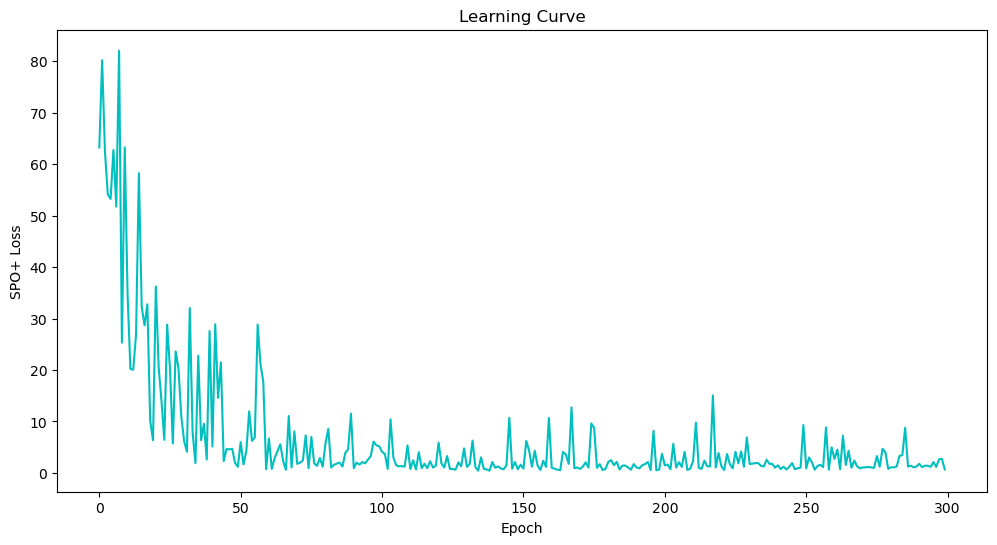

In [58]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(loss_log, color='c')
plt.xlabel('Epoch')
plt.ylabel('SPO+ Loss')
plt.title('Learning Curve')
plt.show()

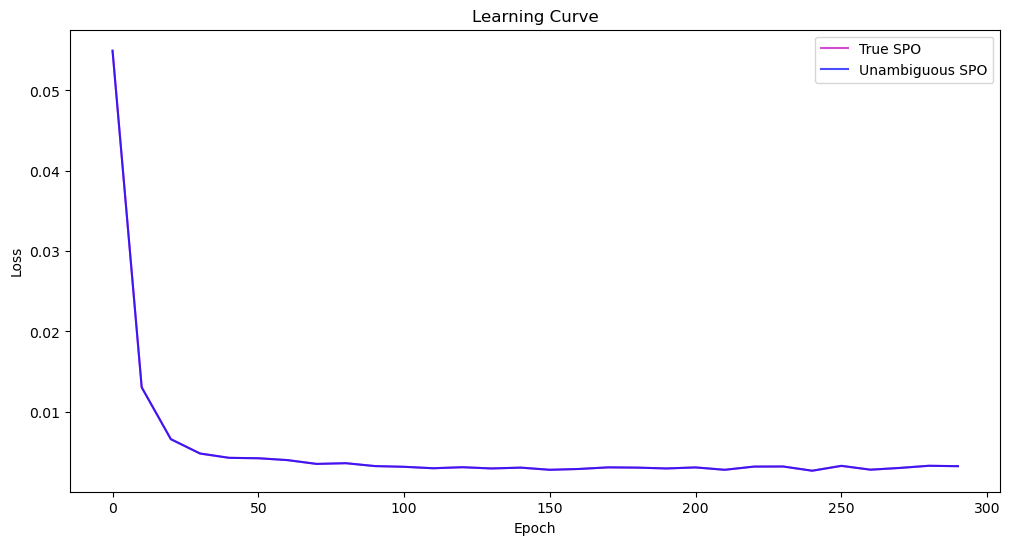

In [59]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(range(0, num_epochs, 10), loss_log_truespo, color='m', alpha=0.7, label='True SPO')
plt.plot(range(0, num_epochs, 10), loss_log_unambspo, color='b', alpha=0.7, label='Unambiguous SPO')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

In [60]:
# evaluate
spoloss = spo.eval.trueSPO(reg, ks_model, ks_loader_test)
print('Normalized true SPO Loss: {:.2f}%'.format(spoloss * 100))
spoloss = spo.eval.unambSPO(reg, ks_model, ks_loader_test)
print('Normalized unambiguous SPO Loss: {:.2f}%'.format(spoloss * 100))

Normalized true SPO Loss: 0.32%
Normalized unambiguous SPO Loss: 0.32%


In [61]:
reg.eval()
# compare solutions
for i, data in enumerate(ks_loader_test):
    # load data
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # predict
    cp = reg(x)
    # convert to numpy
    x = x.to('cpu').detach().numpy()
    c = c.to('cpu').detach().numpy()
    w = w.to('cpu').detach().numpy()
    z = z.to('cpu').detach().numpy()
    cp = cp.to('cpu').detach().numpy()
    for j in range(min(10, batch_size)):
        print('Sample {}:'.format(j))
        print('    True cost:', ', '.join(['{:.2f}'.format(-cost) for cost in c[j]]))
        print('    Pred cost:', ', '.join(['{:.2f}'.format(-cost) for cost in cp[j]]))
        # solve cost from prediction
        ks_model.setObj(cp[j])
        wpj, _ = ks_model.solve()
        zpj = np.dot(c[j], wpj)
        print('    True sol: ' + ', '.join(['{:.0f}'.format(x) for x in w[j]]) + ', True obj: {:.2f}'.format(-z[j,0]))
        print('    Pred sol: '+  ', '.join(['{:.0f}'.format(x) for x in wpj]) + ', Pred obj: {:.2f}'.format(-zpj))
        print()
    break

Sample 0:
    True cost: 10.00, 8.00, 8.00, 9.00, 8.00, 5.00, 8.00, 9.00, 5.00, 6.00, 7.00, 7.00, 7.00, 6.00, 6.00, 9.00, 8.00, 9.00, 9.00, 6.00, 6.00, 7.00, 6.00, 9.00, 8.00, 8.00, 8.00, 5.00, 8.00, 5.00, 5.00, 8.00, 6.00, 6.00, 8.00, 8.00, 5.00, 9.00, 5.00, 6.00, 9.00, 5.00, 8.00, 5.00, 8.00, 8.00, 5.00, 7.00
    Pred cost: 10.58, 8.37, 9.55, 11.58, 7.89, 5.18, 9.72, 10.40, 4.72, 6.61, 8.93, 8.83, 8.34, 6.79, 6.70, 9.69, 7.78, 10.49, 10.91, 6.93, 6.84, 7.82, 7.63, 9.72, 9.38, 8.60, 8.25, 5.90, 10.40, 5.35, 4.37, 8.40, 6.35, 5.96, 8.04, 9.89, 4.18, 9.63, 4.97, 6.55, 9.55, 4.55, 8.40, 5.15, 8.98, 8.98, 5.19, 8.33
    True sol: 1, -0, -0, -0, -0, -0, -0, -0, -0, 1, -0, -0, -0, -0, -0, -0, -0, -0, -0, -0, -0, -0, -0, 1, -0, 1, -0, -0, -0, -0, -0, -0, -0, -0, -0, -0, -0, 1, -0, -0, 1, -0, -0, -0, -0, 1, -0, -0, True obj: 59.00
    Pred sol: 1, -0, -0, -0, -0, -0, -0, -0, -0, 1, -0, -0, 0, -0, -0, -0, -0, -0, -0, -0, -0, -0, -0, 1, -0, 1, -0, -0, -0, -0, -0, -0, -0, -0, -0, -0, -0, 1, -0, 

## Black-Box

In [62]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

In [63]:
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=1e-3)

In [64]:
# set loss
bb = spo.func.blackboxOpt(ks_model, lambd=10, processes=4)
criterion = nn.L1Loss()

Num of cores: 4


In [65]:
# train model
num_epochs = 300
reg.train()
loss_log = []
loss_log_truespo = []
loss_log_unambspo = []
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(ks_loader_train):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # linear regression
        cp = reg(x)
        # black-box optimizer
        wp = bb.apply(cp)
        # objective value
        zp = (wp * c).sum(1).view(-1, 1)
        # loss
        loss = criterion(zp, z)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_log.append(loss.item())
    if (epoch + 1) % 10 == 0:
        # true SPO
        trueloss = spo.eval.trueSPO(reg, ks_model, ks_loader_test)
        loss_log_truespo.append(trueloss)
        # unambiguous SPO 
        unambloss = spo.eval.unambSPO(reg, ks_model, ks_loader_test)
        loss_log_unambspo.append(unambloss)
        print('Epoch {:3}, Loss: {:8.4f}, True SPO Loss: {:7.4f}%, Unambiguous SPO Loss: {:7.4f}%'. \
              format(epoch+1, loss.item(), trueloss*100, unambloss*100))

Epoch  10, Loss:  10.1250, True SPO Loss: 18.9907%, Unambiguous SPO Loss: 18.9907%
Epoch  20, Loss:   4.1250, True SPO Loss:  5.0531%, Unambiguous SPO Loss:  5.0531%
Epoch  30, Loss:   0.6250, True SPO Loss:  1.5090%, Unambiguous SPO Loss:  1.5090%
Epoch  40, Loss:   1.0000, True SPO Loss:  0.8764%, Unambiguous SPO Loss:  0.8764%
Epoch  50, Loss:   0.1250, True SPO Loss:  0.6493%, Unambiguous SPO Loss:  0.6493%
Epoch  60, Loss:   0.3750, True SPO Loss:  0.5338%, Unambiguous SPO Loss:  0.5338%
Epoch  70, Loss:   0.0000, True SPO Loss:  0.4555%, Unambiguous SPO Loss:  0.4555%
Epoch  80, Loss:   0.2500, True SPO Loss:  0.4196%, Unambiguous SPO Loss:  0.4196%
Epoch  90, Loss:   0.2500, True SPO Loss:  0.4157%, Unambiguous SPO Loss:  0.4157%
Epoch 100, Loss:   0.3750, True SPO Loss:  0.3683%, Unambiguous SPO Loss:  0.3683%
Epoch 110, Loss:   0.3750, True SPO Loss:  0.3760%, Unambiguous SPO Loss:  0.3760%
Epoch 120, Loss:   0.2500, True SPO Loss:  0.3798%, Unambiguous SPO Loss:  0.3798%
Epoc

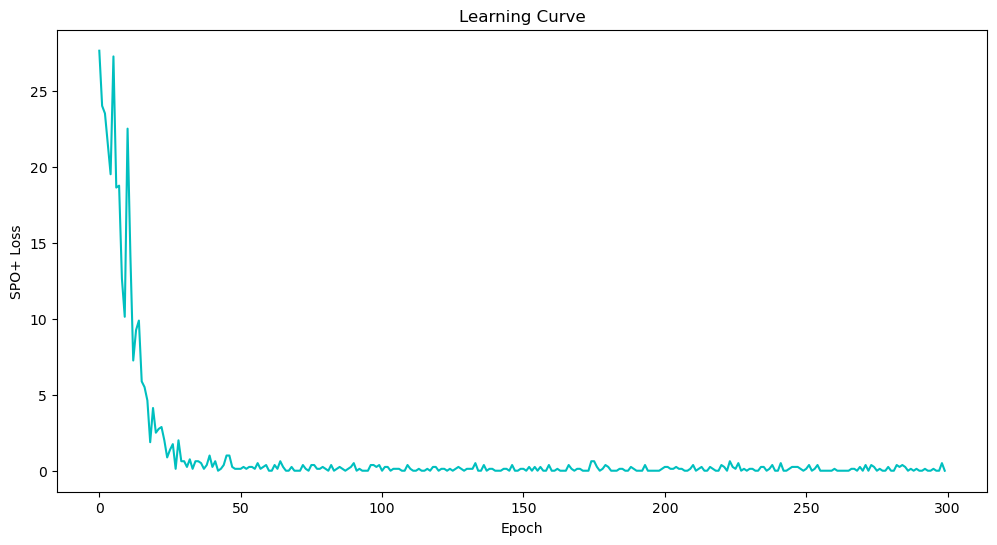

In [66]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(loss_log, color='c')
plt.xlabel('Epoch')
plt.ylabel('SPO+ Loss')
plt.title('Learning Curve')
plt.show()

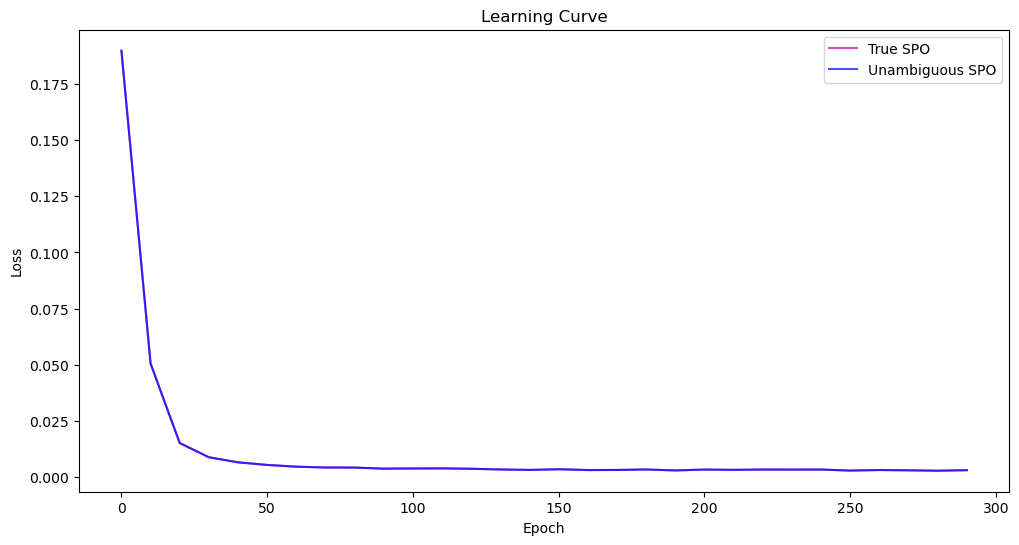

In [67]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(range(0, num_epochs, 10), loss_log_truespo, color='m', alpha=0.7, label='True SPO')
plt.plot(range(0, num_epochs, 10), loss_log_unambspo, color='b', alpha=0.7, label='Unambiguous SPO')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

In [68]:
# evaluate
spoloss = spo.eval.trueSPO(reg, ks_model, ks_loader_test)
print('Normalized true SPO Loss: {:.2f}%'.format(spoloss * 100))
spoloss = spo.eval.unambSPO(reg, ks_model, ks_loader_test)
print('Normalized unambiguous SPO Loss: {:.2f}%'.format(spoloss * 100))

Normalized true SPO Loss: 0.30%
Normalized unambiguous SPO Loss: 0.30%


In [69]:
reg.eval()
# compare solutions
for i, data in enumerate(ks_loader_test):
    # load data
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # predict
    cp = reg(x)
    # convert to numpy
    x = x.to('cpu').detach().numpy()
    c = c.to('cpu').detach().numpy()
    w = w.to('cpu').detach().numpy()
    z = z.to('cpu').detach().numpy()
    cp = cp.to('cpu').detach().numpy()
    for j in range(min(10, batch_size)):
        print('Sample {}:'.format(j))
        print('    True cost:', ', '.join(['{:.2f}'.format(-cost) for cost in c[j]]))
        print('    Pred cost:', ', '.join(['{:.2f}'.format(-cost) for cost in cp[j]]))
        # solve cost from prediction
        ks_model.setObj(cp[j])
        wpj, _ = ks_model.solve()
        zpj = np.dot(c[j], wpj)
        print('    True sol: ' + ', '.join(['{:.0f}'.format(x) for x in w[j]]) + ', True obj: {:.2f}'.format(-z[j,0]))
        print('    Pred sol: '+  ', '.join(['{:.0f}'.format(x) for x in wpj]) + ', Pred obj: {:.2f}'.format(-zpj))
        print()
    break

Sample 0:
    True cost: 10.00, 8.00, 8.00, 9.00, 8.00, 5.00, 8.00, 9.00, 5.00, 6.00, 7.00, 7.00, 7.00, 6.00, 6.00, 9.00, 8.00, 9.00, 9.00, 6.00, 6.00, 7.00, 6.00, 9.00, 8.00, 8.00, 8.00, 5.00, 8.00, 5.00, 5.00, 8.00, 6.00, 6.00, 8.00, 8.00, 5.00, 9.00, 5.00, 6.00, 9.00, 5.00, 8.00, 5.00, 8.00, 8.00, 5.00, 7.00
    Pred cost: 0.44, 0.26, 0.22, 0.34, 0.25, 0.11, 0.23, 0.29, -0.14, 0.21, 0.30, -0.11, 0.22, 0.20, 0.10, 0.33, 0.29, 0.31, 0.39, -0.03, 0.03, 0.29, 0.02, 0.38, 0.30, 0.34, 0.32, 0.12, 0.24, 0.16, -0.04, 0.32, -0.10, 0.04, 0.32, 0.23, -0.15, 0.36, -0.01, 0.11, 0.39, -0.03, 0.26, 0.03, 0.23, 0.34, 0.01, 0.11
    True sol: 1, -0, -0, -0, -0, -0, -0, -0, -0, 1, -0, -0, -0, -0, -0, -0, -0, -0, -0, -0, -0, -0, -0, 1, -0, 1, -0, -0, -0, -0, -0, -0, -0, -0, -0, -0, -0, 1, -0, -0, 1, -0, -0, -0, -0, 1, -0, -0, True obj: 59.00
    Pred sol: 1, -0, -0, -0, -0, -0, -0, -0, 0, 1, -0, 0, -0, -0, -0, -0, -0, -0, -0, 0, -0, -0, -0, 1, -0, 1, -0, -0, -0, -0, 0, -0, 0, -0, -0, -0, 0, 1, 0, -0, 

    True sol: -0, 0, -0, -0, 0, 0, -0, -0, -0, 0, 0, 0, 1, -0, -0, -0, 0, -0, -0, -0, -0, 1, -0, -0, -0, 0, 1, 1, -0, 1, -0, 0, -0, -0, 0, -0, -0, 0, 0, -0, -0, 0, 1, 0, 0, 0, 0, 0, True obj: 110.00
    Pred sol: -0, -0, 0, 0, 1, 0, 0, -0, -0, -0, 0, -0, 1, 0, 0, -0, -0, 0, -0, 0, 0, 0, 0, 0, -0, 1, 1, 1, -0, 1, -0, -0, 0, 0, -0, -0, -0, -0, -0, 0, -0, -0, 0, -0, -0, -0, -0, 0, Pred obj: 109.00



## Black-Box with Regularization 

In [70]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

In [71]:
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=1e-3)

In [72]:
# set loss
bb = spo.func.blackboxOpt(ks_model, lambd=10, processes=4)
criterion = nn.L1Loss()

Num of cores: 4


In [73]:
# train model
num_epochs = 300
lambd = 10
reg.train()
loss_log = []
loss_log_truespo = []
loss_log_unambspo = []
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(ks_loader_train):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # linear regression
        cp = reg(x)
        # black-box optimizer
        wp = spo.func.blackboxOpt.apply(cp)
        # objective value
        zp = (wp * c).sum(1).view(-1, 1)
        # loss
        loss = criterion(zp, z)
        # l1 reg
        l1_lambda = 1e-3
        l1_reg = torch.abs(cp - c).sum(dim=1).mean()
        loss += l1_lambda * l1_reg
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_log.append(loss.item())
    if (epoch + 1) % 10 == 0:
        # true SPO
        trueloss = spo.eval.trueSPO(reg, ks_model, ks_loader_test)
        loss_log_truespo.append(trueloss)
        # unambiguous SPO 
        unambloss = spo.eval.unambSPO(reg, ks_model, ks_loader_test)
        loss_log_unambspo.append(unambloss)
        print('Epoch {:3}, Loss: {:8.4f}, True SPO Loss: {:7.4f}%, Unambiguous SPO Loss: {:7.4f}%'. \
              format(epoch+1, loss.item(), trueloss*100, unambloss*100))

Epoch  10, Loss:  10.8860, True SPO Loss: 15.5518%, Unambiguous SPO Loss: 15.5518%
Epoch  20, Loss:   3.4267, True SPO Loss:  3.8225%, Unambiguous SPO Loss:  3.8225%
Epoch  30, Loss:   1.1857, True SPO Loss:  1.2857%, Unambiguous SPO Loss:  1.2857%
Epoch  40, Loss:   4.2089, True SPO Loss:  0.7506%, Unambiguous SPO Loss:  0.7506%
Epoch  50, Loss:   0.3278, True SPO Loss:  0.6544%, Unambiguous SPO Loss:  0.6544%
Epoch  60, Loss:   0.3174, True SPO Loss:  0.4619%, Unambiguous SPO Loss:  0.4619%
Epoch  70, Loss:   0.3550, True SPO Loss:  0.3760%, Unambiguous SPO Loss:  0.3760%
Epoch  80, Loss:   0.4503, True SPO Loss:  0.3490%, Unambiguous SPO Loss:  0.3490%
Epoch  90, Loss:   0.4259, True SPO Loss:  0.3708%, Unambiguous SPO Loss:  0.3708%
Epoch 100, Loss:   0.5133, True SPO Loss:  0.3554%, Unambiguous SPO Loss:  0.3554%
Epoch 110, Loss:   0.4344, True SPO Loss:  0.3349%, Unambiguous SPO Loss:  0.3349%
Epoch 120, Loss:   0.4685, True SPO Loss:  0.3221%, Unambiguous SPO Loss:  0.3221%
Epoc

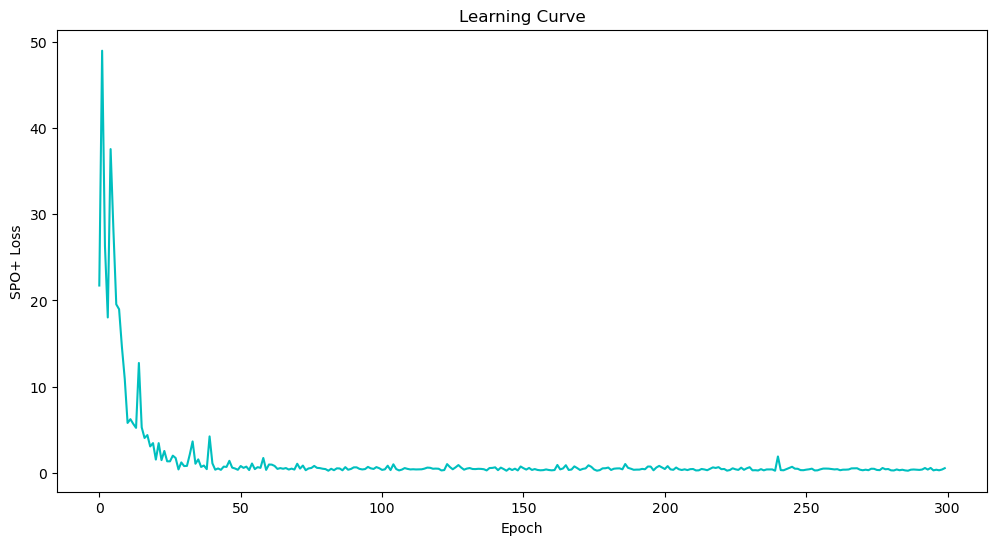

In [74]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(loss_log, color='c')
plt.xlabel('Epoch')
plt.ylabel('SPO+ Loss')
plt.title('Learning Curve')
plt.show()

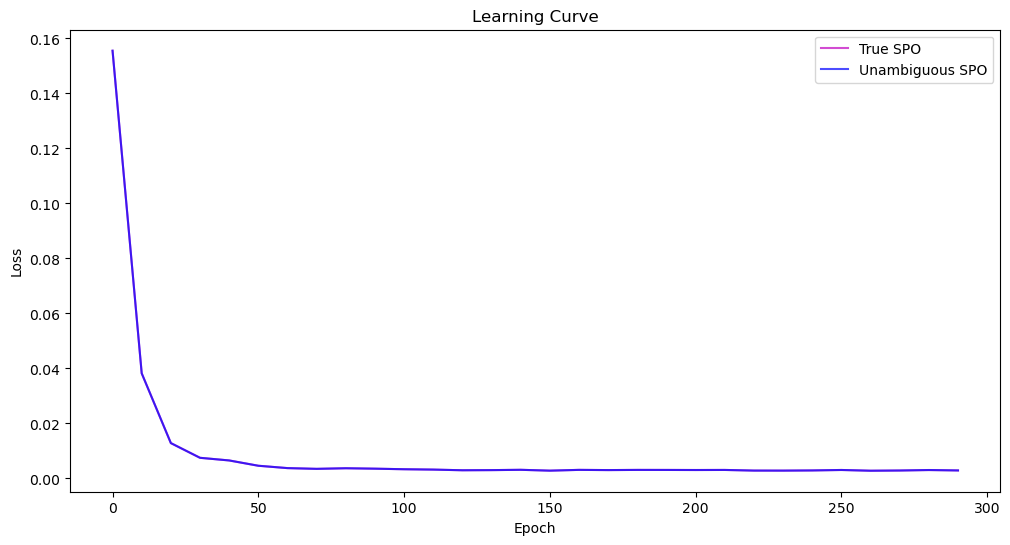

In [75]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(range(0, num_epochs, 10), loss_log_truespo, color='m', alpha=0.7, label='True SPO')
plt.plot(range(0, num_epochs, 10), loss_log_unambspo, color='b', alpha=0.7, label='Unambiguous SPO')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

In [76]:
# evaluate
spoloss = spo.eval.trueSPO(reg, ks_model, ks_loader_test)
print('Normalized true SPO Loss: {:.2f}%'.format(spoloss * 100))
spoloss = spo.eval.unambSPO(reg, ks_model, ks_loader_test)
print('Normalized unambiguous SPO Loss: {:.2f}%'.format(spoloss * 100))

Normalized true SPO Loss: 0.29%
Normalized unambiguous SPO Loss: 0.29%


In [77]:
reg.eval()
# compare solutions
for i, data in enumerate(ks_loader_test):
    # load data
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # predict
    cp = reg(x)
    # convert to numpy
    x = x.to('cpu').detach().numpy()
    c = c.to('cpu').detach().numpy()
    w = w.to('cpu').detach().numpy()
    z = z.to('cpu').detach().numpy()
    cp = cp.to('cpu').detach().numpy()
    for j in range(min(10, batch_size)):
        print('Sample {}:'.format(j))
        print('    True cost:', ', '.join(['{:.2f}'.format(-cost) for cost in c[j]]))
        print('    Pred cost:', ', '.join(['{:.2f}'.format(-cost) for cost in cp[j]]))
        # solve cost from prediction
        ks_model.setObj(cp[j])
        wpj, _ = ks_model.solve()
        zpj = np.dot(c[j], wpj)
        print('    True sol: ' + ', '.join(['{:.0f}'.format(x) for x in w[j]]) + ', True obj: {:.2f}'.format(-z[j,0]))
        print('    Pred sol: '+  ', '.join(['{:.0f}'.format(x) for x in wpj]) + ', Pred obj: {:.2f}'.format(-zpj))
        print()
    break

Sample 0:
    True cost: 10.00, 8.00, 8.00, 9.00, 8.00, 5.00, 8.00, 9.00, 5.00, 6.00, 7.00, 7.00, 7.00, 6.00, 6.00, 9.00, 8.00, 9.00, 9.00, 6.00, 6.00, 7.00, 6.00, 9.00, 8.00, 8.00, 8.00, 5.00, 8.00, 5.00, 5.00, 8.00, 6.00, 6.00, 8.00, 8.00, 5.00, 9.00, 5.00, 6.00, 9.00, 5.00, 8.00, 5.00, 8.00, 8.00, 5.00, 7.00
    Pred cost: 0.57, 0.42, 0.38, 0.53, 0.41, 0.24, 0.45, 0.53, 0.05, 0.34, 0.45, 0.56, 0.38, 0.36, 0.22, 0.49, 0.49, 0.51, 0.55, 0.22, 0.26, 0.45, 0.25, 0.51, 0.48, 0.48, 0.47, 0.26, 0.43, 0.30, 0.16, 0.48, 0.24, 0.24, 0.50, 0.39, 0.06, 0.52, 0.14, 0.26, 0.52, 0.11, 0.42, 0.18, 0.45, 0.52, 0.15, 0.33
    True sol: 1, -0, -0, -0, -0, -0, -0, -0, -0, 1, -0, -0, -0, -0, -0, -0, -0, -0, -0, -0, -0, -0, -0, 1, -0, 1, -0, -0, -0, -0, -0, -0, -0, -0, -0, -0, -0, 1, -0, -0, 1, -0, -0, -0, -0, 1, -0, -0, True obj: 59.00
    Pred sol: 1, -0, -0, -0, -0, -0, -0, -0, -0, 1, -0, -0, -0, -0, -0, -0, -0, -0, -0, -0, -0, -0, -0, 1, -0, 1, -0, -0, -0, -0, -0, -0, -0, -0, -0, -0, -0, 1, -0, -0, 1